In [1]:
#User defines files
from TCN import TemporalConvolutionalNet
from Univariate.Univariate_preprocessing import univariate_preprocessing

import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

The code below will help define some variables need run the program. It will also create training samples, validation samples and addition sample for testing and forecasting.

In [2]:
np.set_printoptions(suppress=True)

window_size = 14 #-> rsi
time_steps= 20 #input length
forecast_size = 1 #shift in y target as well


#load data
# ticer_options = ['APPLE', 'TESLA', 'AT&T', 'S&P500']
ticker = 'APPLE'
cur_dir = Path(os.getcwd())
parent_path = cur_dir.parent
f_path = parent_path / 'data/{}.csv'.format(ticker)
df=pd.read_csv(f_path)

training_sample_size = math.ceil(df.shape[0] * .6)
validation_sample_size = math.ceil(df.shape[0] * .15)
sampling_Style = 'sliding_window' # sliding_window or jump
test_sample_size = math.ceil(df.shape[0] * .25)


sample = df[['Date','Close']] #need to ensure extra data for y-target series forecasting
sample['Date']= pd.to_datetime(sample['Date'], format ='%Y-%m-%d' ) #convert string to date time
sample = sample.set_index('Date')
num_features = sample.shape[1]
sample_df = sample.copy()

training_cutoff = training_sample_size + forecast_size 
validation_cutoff = time_steps + training_cutoff + validation_sample_size + forecast_size
forecast_testing_cut = time_steps + validation_cutoff  + test_sample_size


train = sample_df[:training_cutoff].copy()
val = sample_df[training_cutoff:validation_cutoff].copy()
forecast = sample_df[validation_cutoff:forecast_testing_cut].copy()

Xtrain = train.to_numpy()
xval = val.to_numpy()
xforecast = forecast.to_numpy()

scaler = MinMaxScaler()
scaler.fit(Xtrain)


train['Close'] = scaler.transform(Xtrain)
val['Close'] = scaler.transform(xval)
forecast['Close'] = scaler.transform(xforecast)

X_train, y_train = univariate_preprocessing(num_features,time_steps,train,forecast_size,'sliding_window' ) #or jump

X_val, y_val = univariate_preprocessing(num_features,time_steps,val, forecast_size,'sliding_window')

X_fore, y_fore = univariate_preprocessing(num_features,time_steps,forecast, forecast_size,'sliding_window')


print('Test data size, x-shape, y - shape: ', training_cutoff, X_train.shape, y_train.shape)
print('Validation data size, x-shape, y - shape: ',  validation_cutoff - training_cutoff, X_val.shape, y_val.shape)
print('Forecast data size, x-shape, y - shape: ', forecast_testing_cut - validation_cutoff, X_fore.shape, y_fore.shape)

<ipython-input-2-ccd284e12ba5>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['Date']= pd.to_datetime(sample['Date'], format ='%Y-%m-%d' ) #convert string to date time


Finish resampling
Finish resampling
Finish resampling
Test data size, x-shape, y - shape:  603 torch.Size([583, 1, 20]) torch.Size([583, 1, 20])
Validation data size, x-shape, y - shape:  172 torch.Size([152, 1, 20]) torch.Size([152, 1, 20])
Forecast data size, x-shape, y - shape:  271 torch.Size([208, 1, 20]) torch.Size([208, 1, 20])


Here the data is in the right shape and ready to be inputed in to the model, however we need to define the model first
To define the model we should know the size of the kernel, how many filters and layers the TCN would require

In [3]:
#receptive field = 1 + 2*(kernel_size -1)*(dilation_base^n -1) where n is the nth layer, so we need to solve for n
in_channels = num_features
out_channel = 1
filter_size = 3
num_layers = math.ceil(math.log((X_train.shape[2]-1)/(2*(filter_size - 1))+1,2))
channels = [1,out_channel]
print('Current layers', len(channels))
if len(channels) != num_layers:
    print('You should not have more than {} residual layers or else model will be equivalent to RNN'.format(num_layers))

Current layers 2
You should not have more than 3 residual layers or else model will be equivalent to RNN


Model Definition

In [4]:
model = TemporalConvolutionalNet(in_channels,channels,kernel_size = filter_size,dropout=0.2,weight_normal=True)

layers
1 1
1 1


In [5]:
#training
num_epoch = 500

loss = torch.nn.MSELoss()
# Use stochastic gradient descent to train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.5,0.35), weight_decay=0.35)

for epoch in range(1, num_epoch): 
    
    y_pred = model(X_train)                   # Make predictions (final-layer activations)
    loss_value = loss(y_pred, y_train)                 # Compute loss with respect to predictions
    #print(y_pred)
        
    model.zero_grad()                   # Reset all gradient accumulators to zero (PyTorch thing)
    loss_value.backward()                        # Compute gradient of loss wrt all parameters (backprop!)
    optimizer.step()                    # Use the gradients to take a step with SGD.
        
    if epoch % 10 == 0:
        print("Epoch %d final had loss %.4f" % (epoch, loss_value.item()))
        
        

Epoch 10 final had loss 0.1560
Epoch 20 final had loss 0.1505
Epoch 30 final had loss 0.1408
Epoch 40 final had loss 0.1377
Epoch 50 final had loss 0.1321
Epoch 60 final had loss 0.1236
Epoch 70 final had loss 0.1196
Epoch 80 final had loss 0.1153
Epoch 90 final had loss 0.1120
Epoch 100 final had loss 0.1056
Epoch 110 final had loss 0.1006
Epoch 120 final had loss 0.0971
Epoch 130 final had loss 0.0931
Epoch 140 final had loss 0.0867
Epoch 150 final had loss 0.0830
Epoch 160 final had loss 0.0787
Epoch 170 final had loss 0.0744
Epoch 180 final had loss 0.0714
Epoch 190 final had loss 0.0678
Epoch 200 final had loss 0.0650
Epoch 210 final had loss 0.0603
Epoch 220 final had loss 0.0580
Epoch 230 final had loss 0.0541
Epoch 240 final had loss 0.0516
Epoch 250 final had loss 0.0479
Epoch 260 final had loss 0.0448
Epoch 270 final had loss 0.0436
Epoch 280 final had loss 0.0408
Epoch 290 final had loss 0.0378
Epoch 300 final had loss 0.0352
Epoch 310 final had loss 0.0331
Epoch 320 final h

Here we tested the trained data to see if if the average validation loss is low enough. The reason the average is looked at is because the nature of the data is that it can be volatile. A good model should be able to hand the volatility.

average validaiton loss : 0.0029081462286596528


Text(0.5, 1.0, 'Validation Loss')

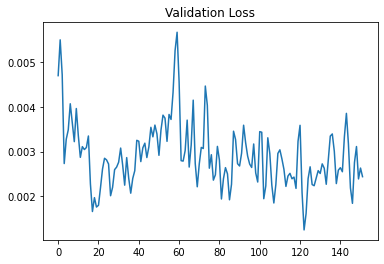

In [6]:
#Validating Model
validation_loss = []
with torch.no_grad():
    model.eval() #stops dropout
    for i in range(X_val.shape[0]):
        x_input = X_val[i:i+1,:,:]
        y_target = y_val[i:i+1,:,:]
        
        y_hat = model(x_input)                   
        val_loss = loss(y_hat, y_target)
        validation_loss.append(val_loss.item())
        
print('average validaiton loss :', np.mean(np.array(validation_loss)))
plt.plot(np.arange(len(validation_loss)),validation_loss,label='Loss')
plt.title('Validation Loss')

Given a new set of data we will input it into the model to determine what it predicts

In [7]:
model.eval()
forecasted = []
for value in range(X_fore.shape[0]):
    sample_input = X_fore[value:value+1,:,:]
    y_pred_fore = model(sample_input)
    #print(X_fore[value:value+1,0:1,:])
    #print(y_pred_fore)
    y_pred_fore_val = y_pred_fore.detach().numpy().reshape(-1) # entirety of model ouput in 1D array
    y_fore_hat = y_pred_fore_val[y_pred_fore.shape[2]-forecast_size:] # forcasted aka shifted y, take last forecast_size elements
    forecasted.append(y_fore_hat[0])
    #print(y_fore_hat)

RMSE Loss for forecasted value(s):  2.7313280910505053


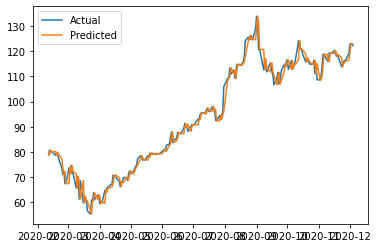

In [8]:
# last forecast_size sample, here these are the actual values of t+1,t+2... 
#assuming sliding window style
forecasted_inv = scaler.inverse_transform(np.array(forecasted).reshape(-1, 1))

y_pred_actual = sample[validation_cutoff:forecast_testing_cut].tail(forecasted_inv.shape[0])

plt.plot(y_pred_actual.index,y_pred_actual.to_numpy(),label = 'Actual')
plt.plot(y_pred_actual.index,forecasted_inv,label = 'Predicted')
plt.legend()
#print('Actual: ',y_pred_actual.to_numpy().reshape(1,-1))
#print('Forecasted: ',forecasted_inv.reshape(1,-1))

forecasted_loss = math.sqrt(mean_squared_error(forecasted_inv,y_pred_actual.to_numpy()))
print('RMSE Loss for forecasted value(s): ', forecasted_loss)